# Benettin Algortihm

In this notebook we will develop the code for the Bennetin algorithm to find the Lyapunov spectrum of L96.

In [ ]:
# Standard Imports

import numpy as np
import numpy.linalg as la
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# L96 Tangent Integrator Import
import l96adaptive as l96

## Functions Needed for the Benettin Algorithm

In [9]:
def posQR(M):
    """ Returns QR decomposition of a matrix with positive diagonals on R.
    Parameter, M: Array that is being decomposed
    """
    Q, R = la.qr(M) # Performing QR decomposition
    signs = np.diag(np.sign(np.diagonal(R))) # Matrix with signs of R diagonal on the diagonal
    Q, R = np.dot(Q, signs), np.dot(signs, R) # Ensuring R Diagonal is positive
    return Q, R

In [10]:
runner = l96.TangentIntegrator(K=4, J=4)

In [11]:
# Initialising orthogonal matrix

eps = 1.e-9
oldQ = eps * np.identity(runner.size)
oldQ[0, 1] = eps * 1

# Will be stretched matrix i.e. P = QR
P = np.random.rand(runner.size, runner.size) 

# Stretching rates after QR decomposition
R = np.random.rand(runner.size, runner.size)

# Time between QR Decompositions
tau = 0.01

In [12]:
looker = l96.TangentTrajectoryObserver(runner)

In [13]:
ftle_ts = []
for i in tqdm(range(1000)):
    # Where we are in phase space before ginelli step
    phase_state = runner.state
    time = runner.time

    # Stretching first column
    runner.set_state(phase_state, oldQ.T[0]) # First column of Q is ic for TLE
    runner.integrate(tau)

    # First column of Stretched matirx
    P[:, 0] = runner.tangent_state

    # Stretching the rest of the columns
    for i, column in enumerate(oldQ.T[1:]):

        # Reseting to where we were in phase space
        runner.set_state(phase_state, column)
        runner.time = time

        runner.integrate(tau)
        P[:, i + 1] = runner.tangent_state
    
    oldQ, R = posQR(P)
    ftle = np.log(np.diag(R))/(tau)
    ftle_ts.append(ftle)

In [14]:
F = np.vstack(ftle_ts)

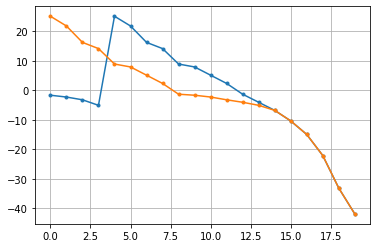

In [15]:
ftle = np.flip(np.sort(np.mean(F, axis=0)))
plt.plot(np.mean(F, axis=0), '.-')
plt.plot(ftle, '.-')
plt.grid()
plt.show()

In [19]:
ftle

array([ 25.12681872,  21.81743264,  16.25697289,  14.15198315,
         8.91229157,   7.91756245,   5.12621069,   2.32561478,
        -1.33155206,  -1.6740923 ,  -2.28930423,  -3.22723793,
        -4.06445996,  -5.0986719 ,  -6.80924114, -10.38970326,
       -14.9782722 , -22.12780268, -33.18095177, -41.94923783])

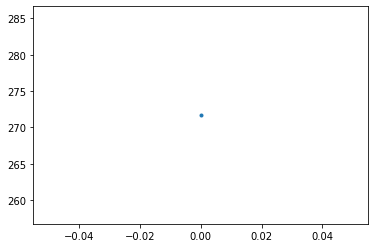

In [18]:
plt.plot(np.var(ftle), '.-')

In [ ]:
from scipy.stats import gaussian_kde
def kde_pdf(samples, title, xlabel='', save=None):
    fig, ax = plt.subplots()
    x_d = np.linspace(samples.min() - 1, samples.max() + 1, 1000) # Grid we evaluate PDF on
    kde = gaussian_kde(samples) # KDE. Using Gaussian ker
    pdf = kde.evaluate(x_d)
    ax.plot(x_d, pdf)
    ax.set_ylabel('$\\rho$')
    ax.set_xlabel(xlabel)
    ax.plot(samples, np.full_like(samples, -0.01), 'k*', label='samples')
    #ax.legend()
    ax.grid()
    ax.set_title(title)
    if (save!=None):
        print(f'Saving plot at {save}')
        fig.savefig(save, dpi=1200)
    fig.show()

In [ ]:
kde_pdf(F[1:, -1], 'Last FTLE')
kde_pdf(F[1:, -2], 'Last FTLE')
kde_pdf(F[1:, -3], 'Last FTLE')
kde_pdf(F[1:, -4], 'Last FTLE')

In [ ]:
plt.plot(F[1:, -1], '.-')
plt.plot(F[1:, -2])

In [ ]:
plt.plot([np.mean(F[1:i, -2]) for i in range(1, 1000)])